In this notebook, I detail the method by which a grid is generated and subsequently filled.

In [1]:
import pickle
import numpy as np

WEEKDAY_GRID_SIZE = 15

In [2]:
#  if a square is empty, 0.  If a square is black, 1.
def bin_gridify(raw_grids):
    binary_grids = []
    for grid in raw_grids:
        new_grid = [1 if x == "." else 0 for x in grid ]
        binary_grids = binary_grids + [new_grid]
    return binary_grids


In [3]:
dow_dict = pickle.load(open('../bin/pickles/dow_dict.pickle','rb'))

In [4]:
data_set = []
for day in dow_dict.keys():
    grid_list = dow_dict[day]
    grid_list = bin_gridify(grid_list)
    data_set = data_set + [grid_list]

In [5]:
import matplotlib.pyplot as plt

mon = data_set[0]
mon = [np.array(grid).reshape(15,15) for grid in mon if len(grid) == (15*15)]


In [6]:
# defining a function that checks the symmetry of the
def check_symmetry(dim,grid):
    leng = dim*dim
    half = (leng-1)//2
    array = grid.reshape(leng,)
    front = array[:half]
    back = array[-half:]
    return (front == np.flip(back)).all()

In [7]:
check_symmetry(15,mon[0])

True

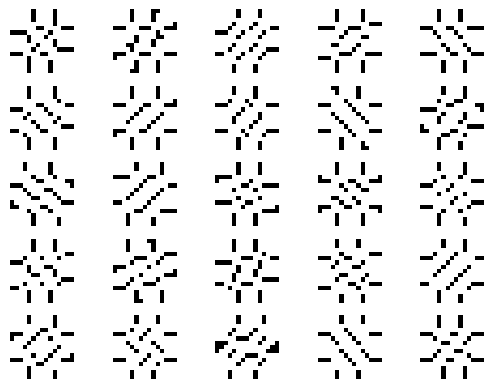

In [8]:
for i in range(25):
    plt.subplot(5,5,1+i)
    plt.axis('off')
    plt.imshow(mon[i],cmap="Greys")
plt.show()

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# creating a gan, we start by defining a standalone discriminator
from keras import Sequential
from keras.layers import LeakyReLU, Conv2D, Dropout, Flatten, Dense
from keras.optimizers import Adam


def define_discriminator(in_shape=(15,15,1)):
    model = Sequential()

    model.add(Conv2D(64, (3,3), strides=(2,2),padding='same',input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0,4))

    model.add(Conv2D(64,(3,3),strides=(2,2),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))


    opt = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))


# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = np.ones((n_samples,1))
	return X, y


# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = np.random.binomial(.5,.5,15*15*n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 15, 15, 1))
	# generate 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

model = define_discriminator()
model.summary()

ModuleNotFoundError: No module named 'keras'

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='../exports/discriminator.png', show_shapes=True, show_layer_names=True);

In [12]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model


In [17]:

X = np.expand_dims(mon,axis=-1)
X = X.astype('float32')

model = define_discriminator()
# load image data
dataset = X
# fit the model
train_discriminator(model, dataset)

TypeError: in user code:

    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:424 call
        return self._run_internal_graph(
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:230 call
        output = control_flow_util.smart_cond(training, dropped_inputs,
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/utils/control_flow_util.py:114 smart_cond
        return smart_module.smart_cond(
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/framework/smart_cond.py:54 smart_cond
        return true_fn()
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:226 dropped_inputs
        noise_shape=self._get_noise_shape(inputs),
    /home/thowe/miniconda3/envs/cudnn-1/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:215 _get_noise_shape
        for i, value in enumerate(self.noise_shape):

    TypeError: 'int' object is not iterable


In [ ]:
generate_fake_samples(1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 3200)              1603200   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 128)         262272    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 15, 15, 128)       147584    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 15, 15, 128)      

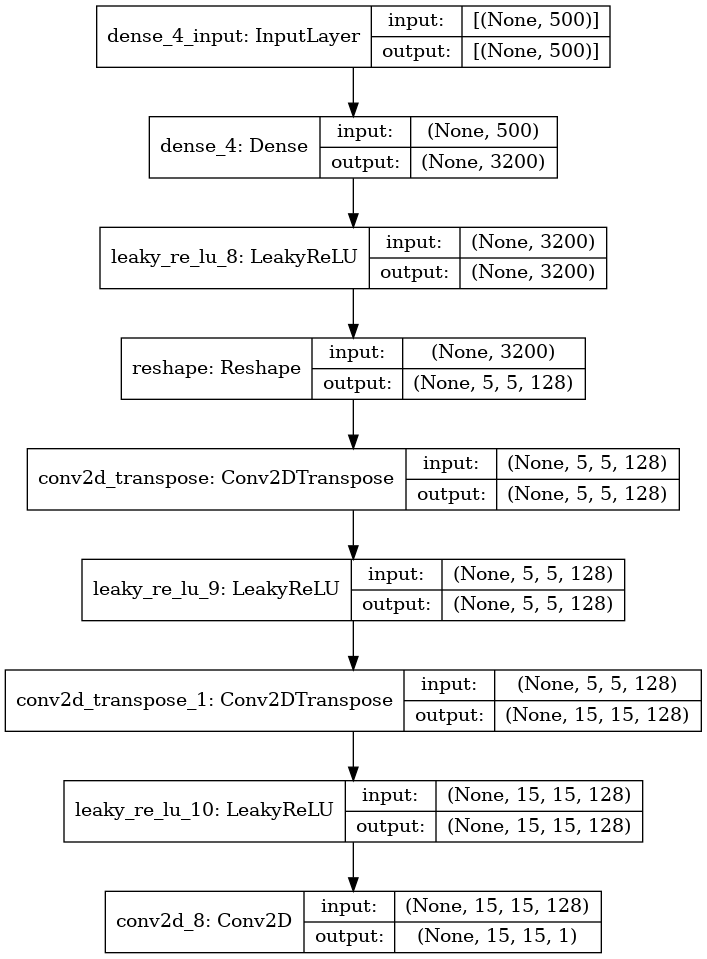

In [18]:
from keras.layers import Reshape, Conv2DTranspose
# creating the generator model
def define_generator(dim):
    model = Sequential()

    # creating nodes for a 15 * 15 grid
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes,input_dim=dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5,5,128)))

    model.add(Conv2DTranspose(128, (4,4), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(128,(3,3),strides=(3,3),padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1,(7,7), activation='sigmoid',padding='same'))
    return model

dim = 500

model = define_generator(dim)
model.summary()

plot_model(model,to_file='../exports/generator.png',show_shapes=True,show_layer_names=True)




In [19]:
# generate points in latent space as input for the generator
from numpy.random import randn
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

def generate_fake_samples(g_model,latent_dim,n_samples):
    # generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = np.zeros((n_samples, 1))
	return X, y

In [20]:
# X, _ = generate_fake_samples(model, dim, 25)
# # plot the generated samples
# for i in range(25):
# 	# define subplot
# 	plt.subplot(5, 5, 1 + i)
# 	# turn off axis labels
# 	plt.axis('off')
# 	# plot single image
# 	plt.imshow(X[i, :, :, 0], cmap='gray_r')
# # show the figure
# plt.show()

In [21]:
def gan_builder(disc_model,gen_model):
    disc_model.trainable=True
    model = Sequential()
    model.add(gen_model)
    model.add(disc_model)
    optimizer = Adam(lr=0.0002,beta_1=0.5)
    model.compile(loss='binary_crossentropy',optimizer=optimizer)
    return model

In [22]:
# size of the latent space
dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(dim)
# create the gan
gan_model = gan_builder(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

ValueError: Input 0 of layer dense_6 is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape (None, 1)

In [ ]:
def train_gan(disc,gen,data,dim,n_epochs=100,n_batch=256):
    #batches per epoch
    bpe = data.shape // n_batch
    bpe = int(bpe)
    # size of half batch
    half_b = n_batch//2
    half_b = int(half_b)